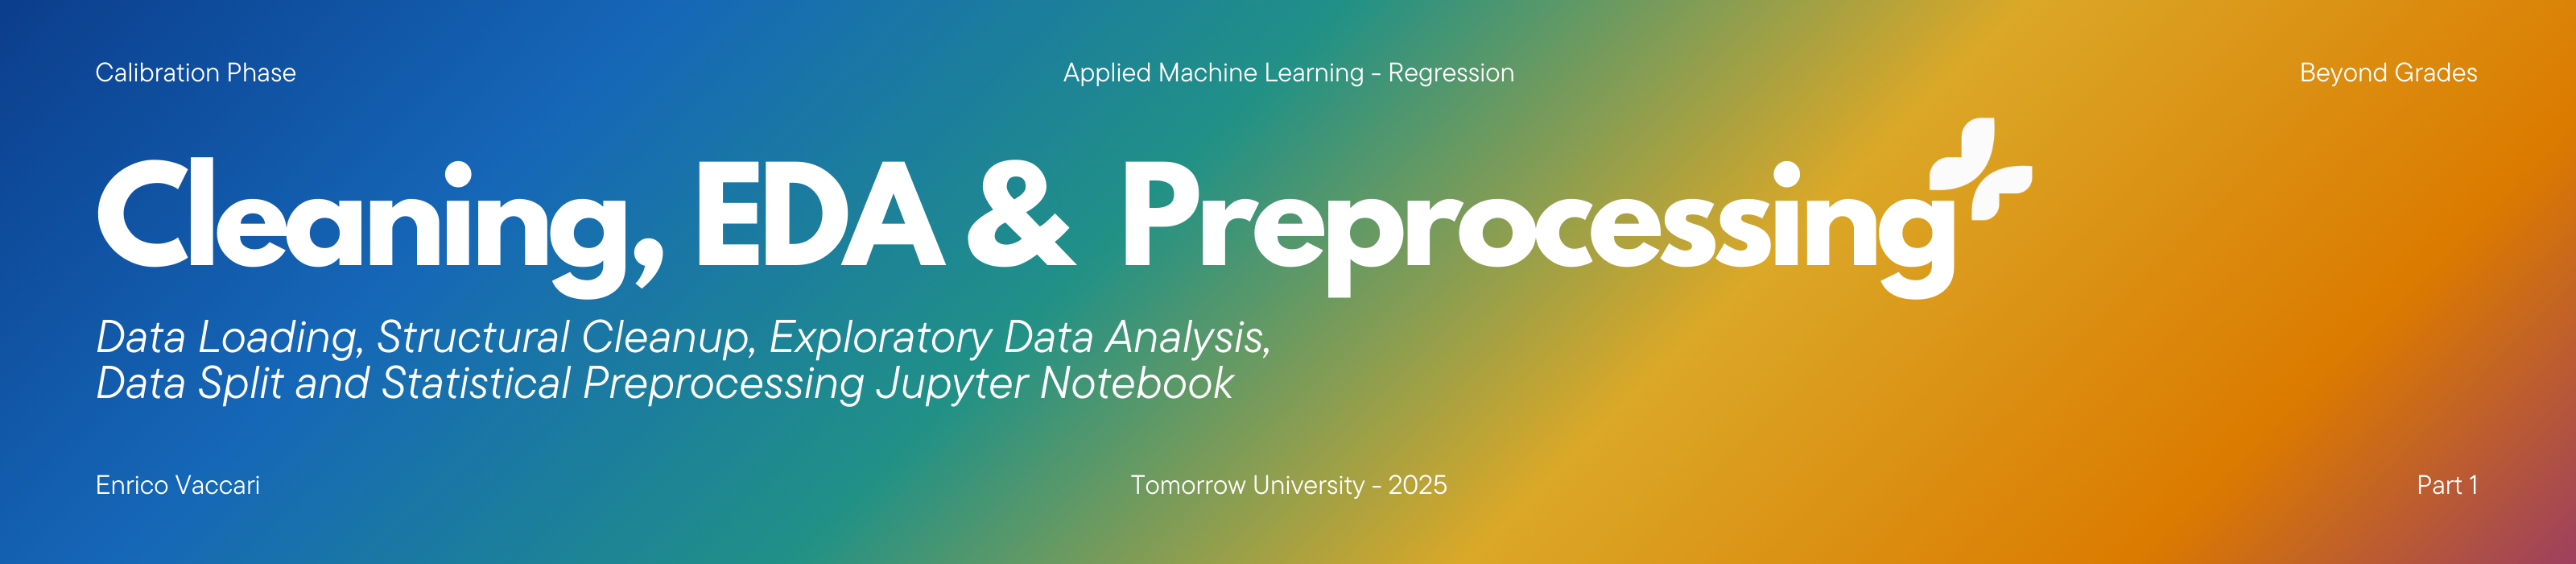

In [1]:
from IPython.display import Image, HTML, display
display(Image("../extra/images/Beyond_Grades_Banner_01.png", width=1600))

# 📚 Project Index

- [1 - IMPORTS](#1---imports)
- [2 - DATASET LOAD](#2---dataset-load)
- [3 - STATISTICAL PREPROCESSING](#6---statistical-preprocessing)
  - [3.1 - Encoding categoricals](#61---encoding-categoricals)
  - [3.2 - Numeric scaling / normalization](#62---numeric-scaling--normalization)
  - [3.3 - Outliers & imputation](#63---outliers--imputation)
  - [3.4 - Other steps](#64---other-steps)

---
># 1 - IMPORTS

## SETUP PROJECT AND PATH to src\

why: in jupyter notebook I can't use __file__ to get to the project dir, so I need to use Path-cwd

In [1]:
# -------------------------------------------------------------------
# PROJECT IMPORTS (centralized setup)
# -------------------------------------------------------------------
import sys
from pathlib import Path

# Assicurati che src/project sia nel sys.path
PROJECT_ROOT = Path.cwd().resolve().parent
PROJECT_PATH = PROJECT_ROOT / "src" / "project"

if str(PROJECT_PATH) not in sys.path:
    sys.path.insert(0, str(PROJECT_PATH))

# Import centralizzato
from imports import *

cleaning.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\data
preprocessing.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\data
splitting.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\data
analysis.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\features
utils.py functions module imported from: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\U

---
># 2 - DATASET LOAD

In [ ]:
x_train_path = "../data/interim/X_train_aftersplit.xlsx"
y_train_path = "../data/interim/y_train_aftersplit.xlsx"
try:
    X_train = utils.load_student_dataset(x_train_path)
    print('x_train successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    y_train = utils.load_student_dataset(y_train_path)
    print('y_train loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

# put x_train and y_train together temporarily for EDA
eda_train = X_train.copy()
eda_train["GPA"] = y_train


X_train_path = "../data/interim/X_train_aftersplit.xlsx"
y_train_path = "../data/interim/y_train_aftersplit.xlsx"

X_test_path = "../data/interim/X_test_aftersplit.xlsx"
y_test_path = "../data/interim/y_test_aftersplit.xlsx"

try:
    X_train = utils.load_student_dataset(X_train_path)
    print('X_train successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    y_train = utils.load_student_dataset(y_train_path)
    print('y_train loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    X_test = utils.load_student_dataset(X_test_path)
    print('X_test successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

try:
    y_test = utils.load_student_dataset(y_test_path)
    print('y_test loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')


print("Ready for Feature Classification:")
print(f"  Training features: {X_train.shape}")
print(f"  Features to classify: {len(X_train.columns)}")
print(f"  Data integrity verified: ✅")

x_train successfully.
y_train loaded successfully.


In [6]:
# Categorical
categorical_cols = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports",
    "Music", "Volunteering"
]

for col in categorical_cols:
    eda_train[col] = eda_train[col].astype("category")

numeric_cols = []
for col in eda_train.columns:
    if col not in categorical_cols:
        numeric_cols.append(col)

print(numeric_cols)
eda_train.info()

['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                1913 non-null   int64   
 1   Gender             1913 non-null   category
 2   Ethnicity          1913 non-null   category
 3   ParentalEducation  1913 non-null   category
 4   StudyTimeWeekly    1913 non-null   float64 
 5   Absences           1913 non-null   int64   
 6   Tutoring           1913 non-null   category
 7   ParentalSupport    1913 non-null   category
 8   Extracurricular    1913 non-null   category
 9   Sports             1913 non-null   category
 10  Music              1913 non-null   category
 11  Volunteering       1913 non-null   category
 12  GPA                1913 non-null   float64 
dtypes: category(9), float64(2), int64(2)
memory usage: 78.1 KB


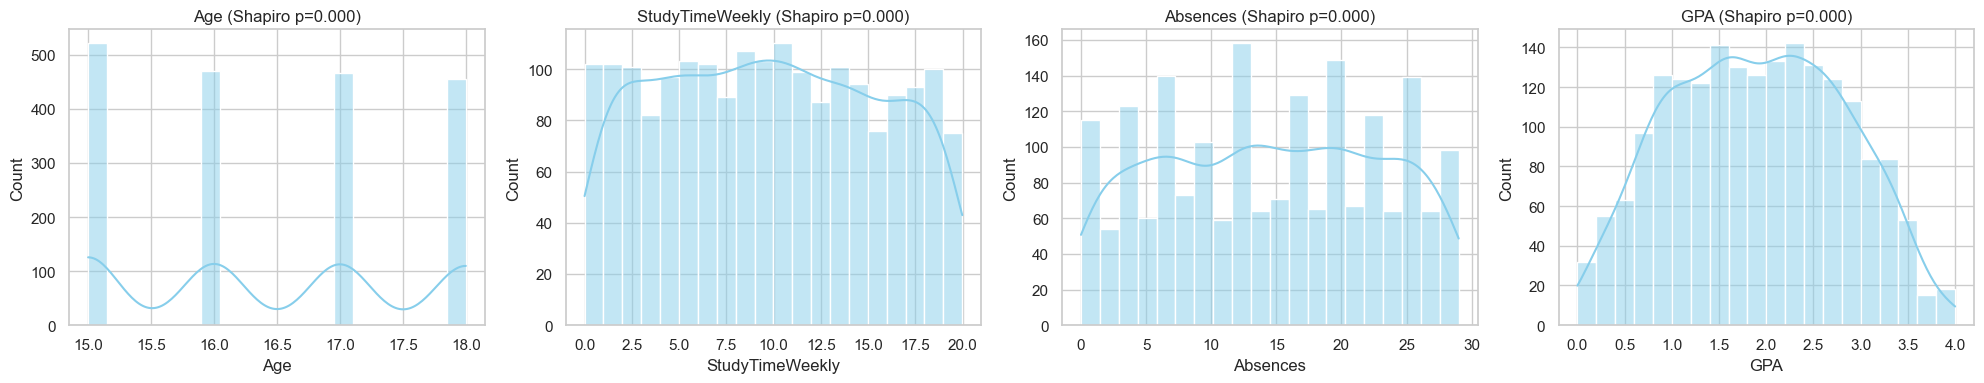

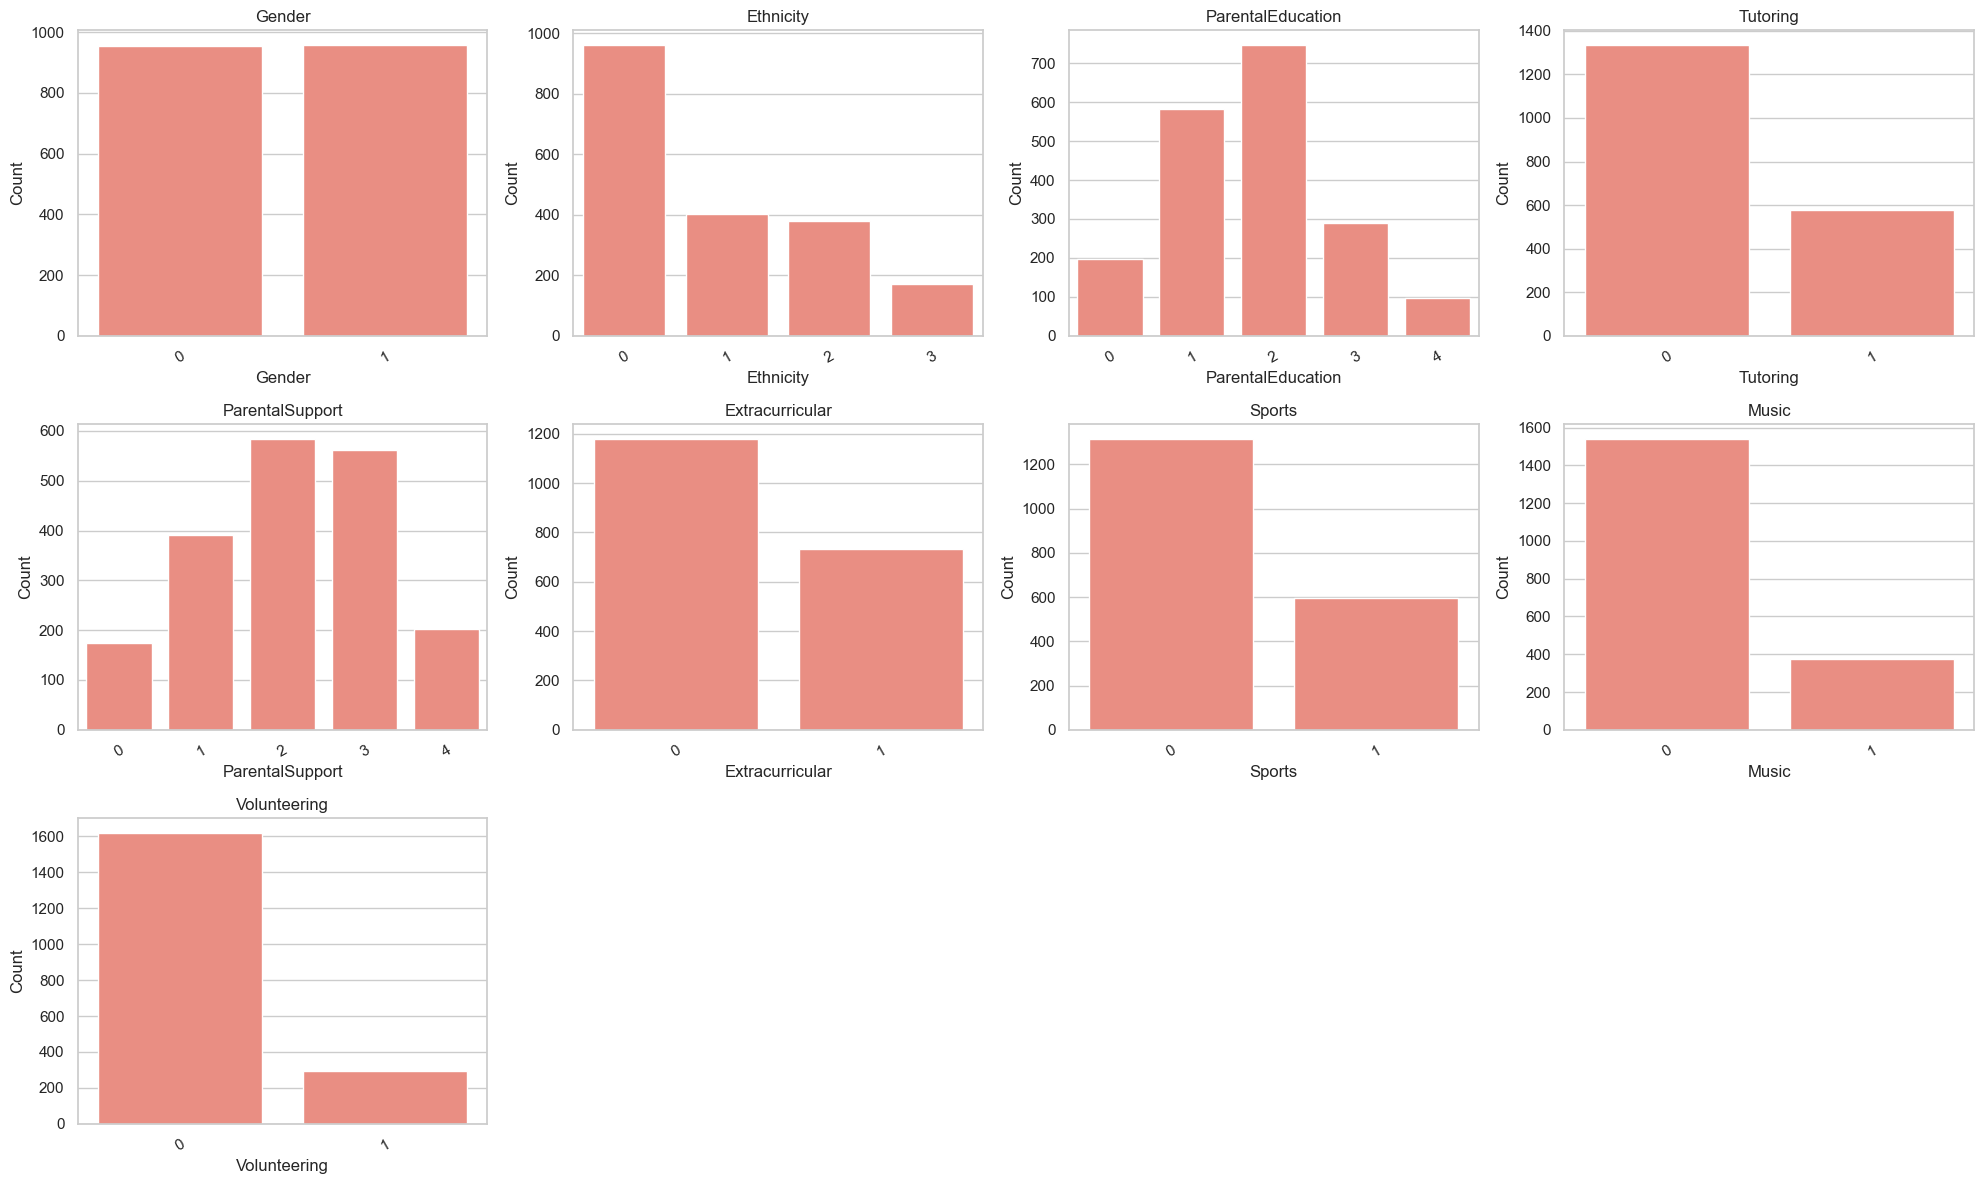

{'Age': {'stat': 0.8531352823481223, 'p': 5.967849208407726e-39, 'normal_at_0.05': False}, 'StudyTimeWeekly': {'stat': 0.9581784642687354, 'p': 5.00432721875086e-23, 'normal_at_0.05': False}, 'Absences': {'stat': 0.9577104390009953, 'p': 3.780177086816723e-23, 'normal_at_0.05': False}, 'GPA': {'stat': 0.984250699771272, 'p': 1.1366508909980314e-13, 'normal_at_0.05': False}}


In [7]:
results = analysis.plot_distributions_by_type(
    eda_train,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    check_normality=True,
    bins=20,
    max_cols_per_row=4
)

# Normality summary for numeric features
print(results["normality"])


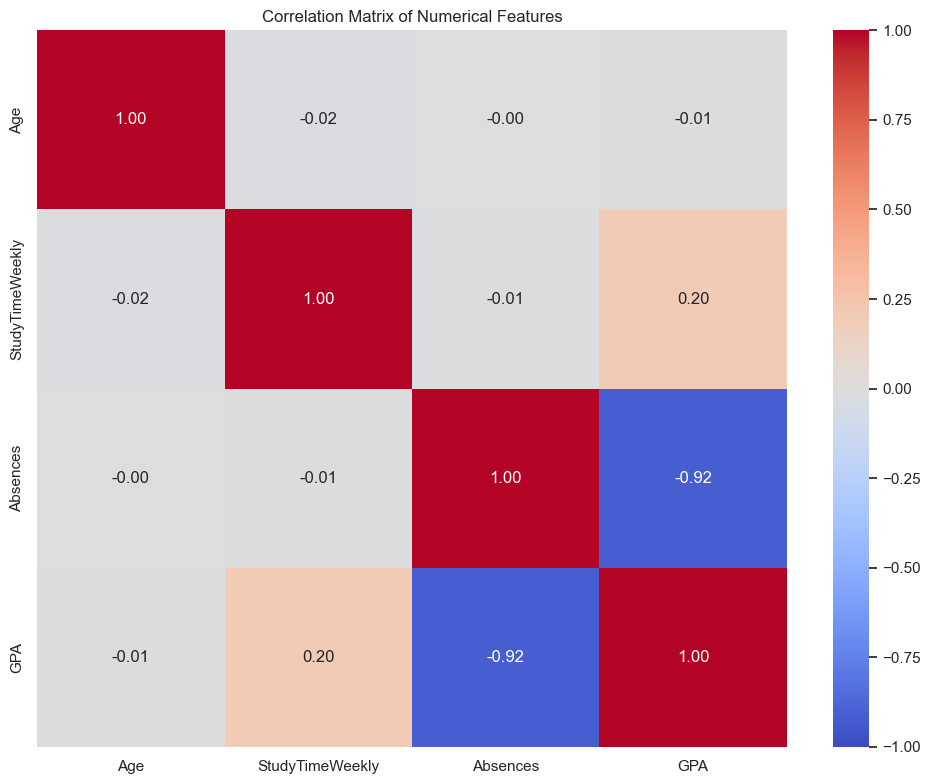

In [ ]:
analysis.correlations(eda_train, numeric_cols)

# A note on EDA: Using several visualization methods helps uncover hidden patterns. Each plot gives a different perspective on the data.

In [ ]:
 # correlations between numeric and categorical

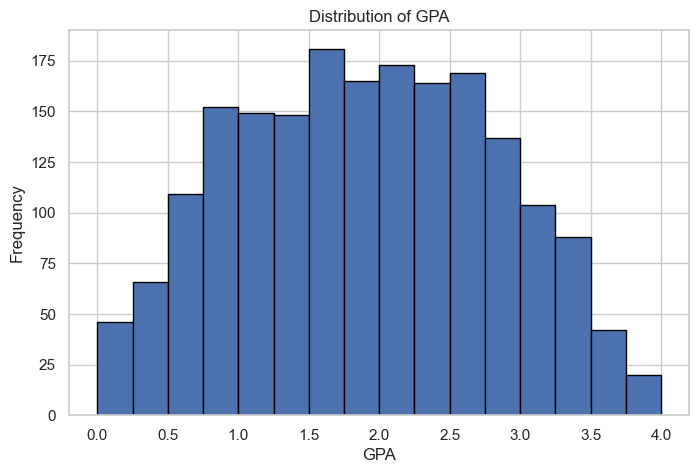

C:\Users\Vaccari\AppData\Local\Temp\ipykernel_39428\628669590.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_gender, labels=genders)


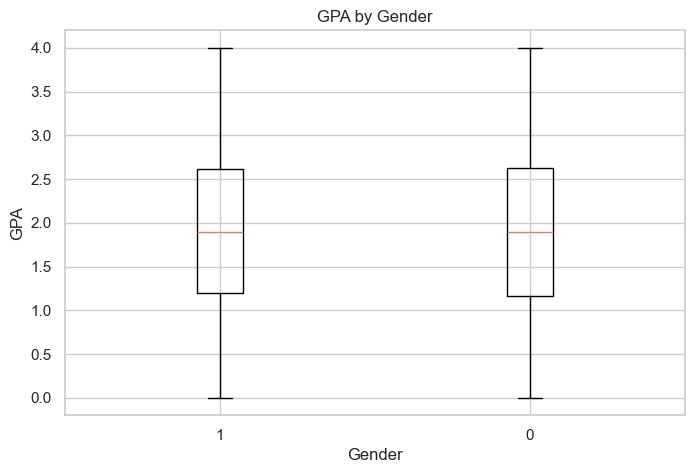

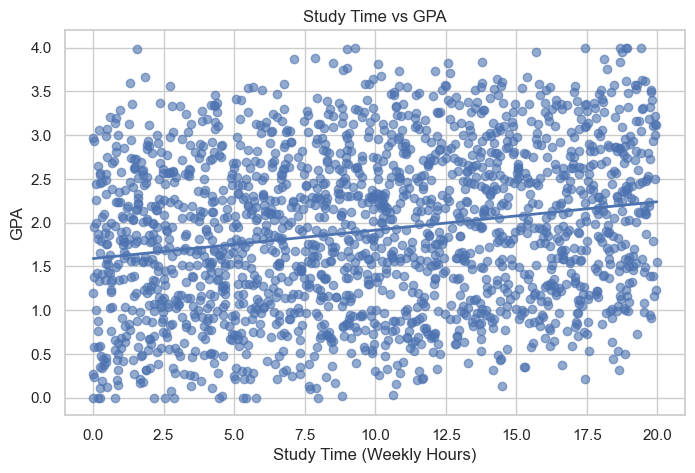


Correlation between Study Time and GPA: 0.2


C:\Users\Vaccari\AppData\Local\Temp\ipykernel_39428\628669590.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_cat, labels=categories)


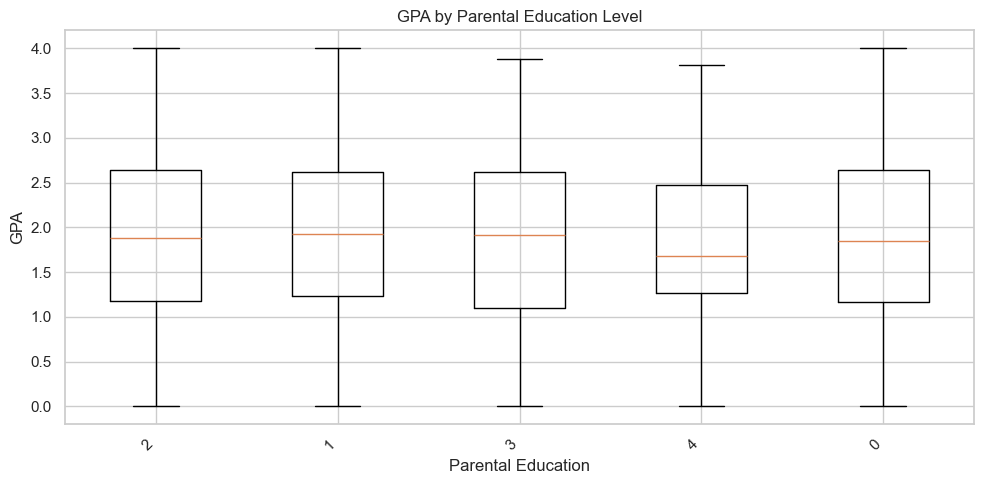


Mean GPA by activity participation:
Extracurricular Sports Music Volunteering  Mean_GPA
              1      0     1            1  2.372915
              0      0     1            1  2.340287
              0      1     1            0  2.203370
              1      1     0            0  2.148995
              1      0     1            0  2.127736
              0      1     0            1  2.013556
              0      1     1            1  2.011486
              1      1     0            1  2.007150
              1      0     0            1  1.992110
              0      0     1            0  1.952602
              1      0     0            0  1.936860
              0      1     0            0  1.841098
              1      1     1            0  1.825104
              1      1     1            1  1.815219
              0      0     0            0  1.765665
              0      0     0            1  1.626088


In [10]:
# ====== 1) GPA Distribution ======
plt.figure(figsize=(8,5))
plt.hist(eda_train["GPA"].dropna(), bins=np.arange(eda_train["GPA"].min(), eda_train["GPA"].max()+0.25, 0.25), edgecolor="black")
plt.title("Distribution of GPA")
plt.xlabel("GPA")
plt.ylabel("Frequency")
plt.show()



# ====== 2) Gender-wise GPA Boxplot ======
if {"Gender", "GPA"}.issubset(eda_train.columns):
    # ensure categorical ordering if needed
    plt.figure(figsize=(8,5))
    genders = eda_train["Gender"].dropna().unique().tolist()
    data_by_gender = [eda_train.loc[eda_train["Gender"] == g, "GPA"].dropna().values for g in genders]
    plt.boxplot(data_by_gender, labels=genders)
    plt.title("GPA by Gender")
    plt.xlabel("Gender")
    plt.ylabel("GPA")
    plt.show()

# ====== 3) Study Time vs GPA (scatter + linear fit) ======
if {"StudyTimeWeekly", "GPA"}.issubset(eda_train.columns):
    x = eda_train["StudyTimeWeekly"]
    y = eda_train["GPA"]
    mask = x.notna() & y.notna()
    xv, yv = x[mask].values, y[mask].values

    plt.figure(figsize=(8,5))
    plt.scatter(xv, yv, alpha=0.6)
    # linear fit
    if len(xv) >= 2:
        m, b = np.polyfit(xv, yv, 1)
        xs = np.linspace(xv.min(), xv.max(), 200)
        plt.plot(xs, m*xs + b, linewidth=2)
    plt.title("Study Time vs GPA")
    plt.xlabel("Study Time (Weekly Hours)")
    plt.ylabel("GPA")
    plt.show()

    # Pearson correlation
    if len(xv) > 1:
        corr = np.corrcoef(xv, yv)[0,1]
        print("\nCorrelation between Study Time and GPA:", round(float(corr), 2))

# ====== 4) GPA by Parental Education ======
if {"ParentalEducation", "GPA"}.issubset(eda_train.columns):
    plt.figure(figsize=(10,5))
    categories = eda_train["ParentalEducation"].dropna().astype(str).unique().tolist()
    data_by_cat = [eda_train.loc[eda_train["ParentalEducation"].astype(str) == c, "GPA"].dropna().values for c in categories]
    plt.boxplot(data_by_cat, labels=categories)
    plt.title("GPA by Parental Education Level")
    plt.xlabel("Parental Education")
    plt.ylabel("GPA")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# ====== 5) Summary: Mean GPA by activity participation ======
activity_cols = ["Extracurricular", "Sports", "Music", "Volunteering"]
present_cols = [c for c in activity_cols if c in eda_train.columns]

if present_cols:
    # Coerce to categorical/binary-friendly strings to avoid weird group keys
    temp = eda_train.copy()
    for c in present_cols:
        temp[c] = temp[c].astype(str)

    activity_summary = (
        temp.groupby(present_cols, dropna=False)["GPA"]
            .mean()
            .reset_index(name="Mean_GPA")
            .sort_values("Mean_GPA", ascending=False)
    )
    print("\nMean GPA by activity participation:")
    print(activity_summary.to_string(index=False))

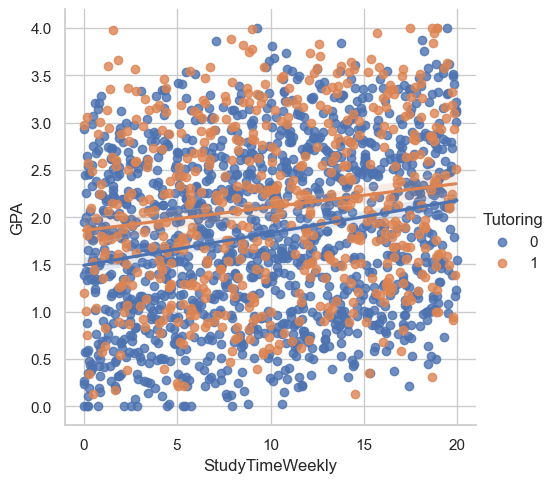

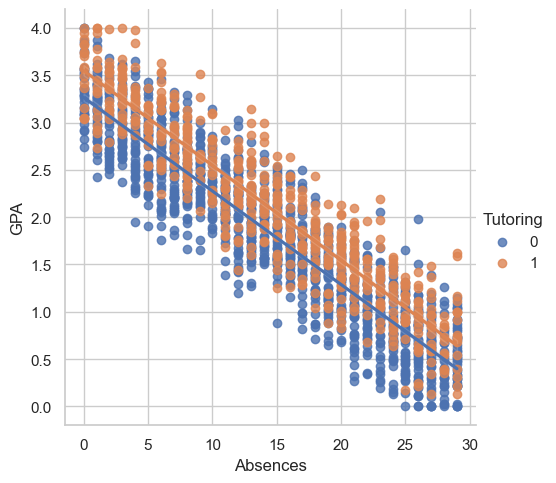

In [11]:
import seaborn as sns
sns.lmplot(data=eda_train, x='StudyTimeWeekly', y='GPA', hue='Tutoring')
plt.show()

sns.lmplot(data=eda_train, x='Absences', y='GPA', hue='Tutoring')
plt.show()

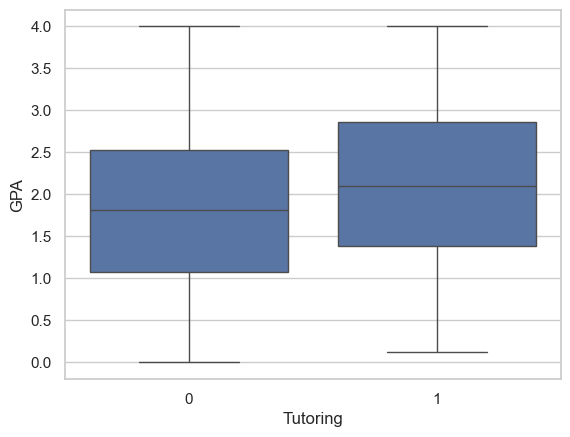

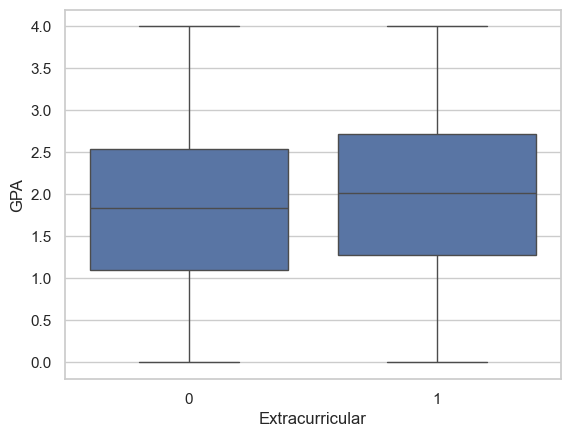

C:\Users\Vaccari\AppData\Local\Temp\ipykernel_39428\1152337769.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  sns.boxplot(data=eda_train.replace({'Gender':{0:'Male', 1:'Female'}}), x='Gender', y='GPA')


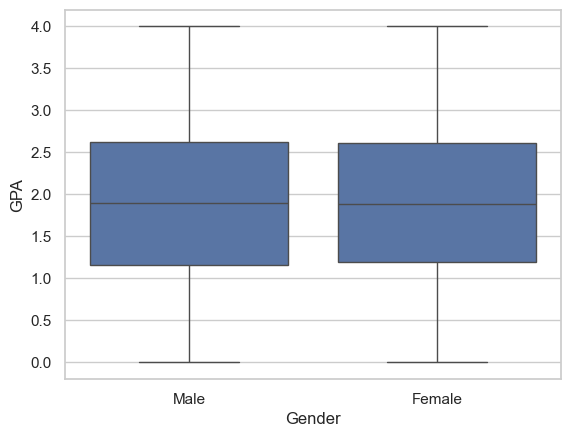

In [12]:
sns.boxplot(data=eda_train, x='Tutoring', y='GPA')
plt.show()
sns.boxplot(data=eda_train, x='Extracurricular', y='GPA')
plt.show()
sns.boxplot(data=eda_train.replace({'Gender':{0:'Male', 1:'Female'}}), x='Gender', y='GPA')
plt.show()

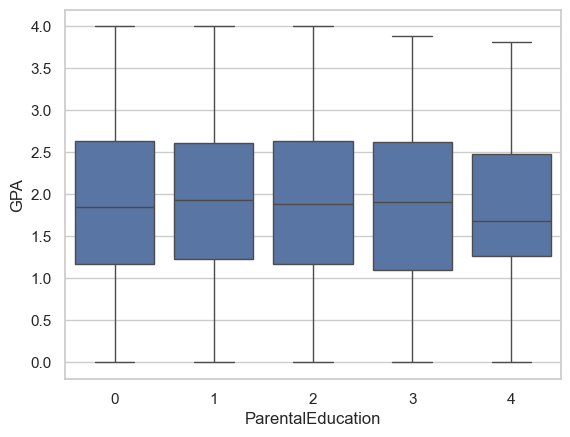

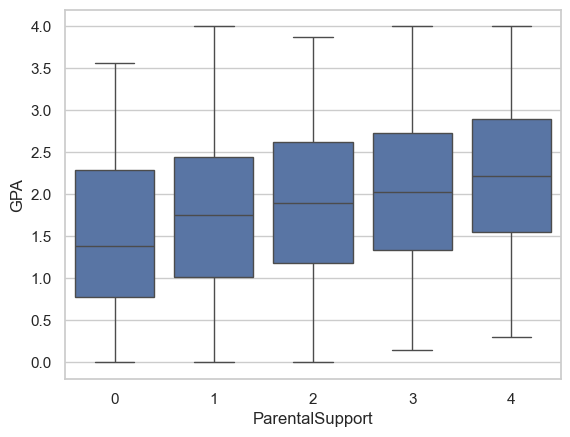

In [13]:
sns.boxplot(data=eda_train, x='ParentalEducation', y='GPA')
plt.show()
sns.boxplot(data=eda_train, x='ParentalSupport', y='GPA')
plt.show()

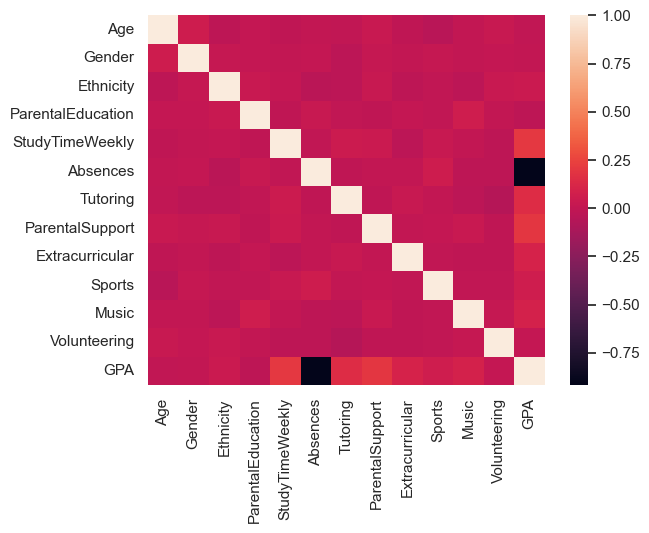

In [14]:
sns.heatmap(data=eda_train.corr())
plt.show()

In [ ]:
# --- helper to get a dense OneHotEncoder across sklearn versions ---
def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.4
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn < 1.4


def create_preprocessing_pipeline_simple(X_train, y_train,
                                         numeric_features, categorical_features,
                                         k_best=10):
    """
    Fit preprocessing on training data (numeric + categorical) and return transformed X_train + fitted objects.
      - Numeric: median imputation -> StandardScaler
      - Categorical: most_frequent imputation -> OneHotEncoder (dense)
      - Optional: SelectKBest(f_regression, k=k_best)
    """
    # --- numeric ---
    num_imputer = SimpleImputer(strategy="median")
    Xn_imp = num_imputer.fit_transform(X_train[numeric_features])

    scaler = StandardScaler()
    Xn = scaler.fit_transform(Xn_imp)

    # --- categorical ---
    cat_imputer = SimpleImputer(strategy="most_frequent")
    Xc_imp = cat_imputer.fit_transform(X_train[categorical_features])

    ohe = _make_ohe()
    Xc = ohe.fit_transform(Xc_imp)

    # --- concatenate ---
    X_all = np.hstack([Xn, Xc])

    # --- feature names before selection ---
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()
    all_feature_names = list(numeric_features) + cat_names

    # --- optional K-best selection ---
    selector = None
    if k_best is not None:
        selector = SelectKBest(score_func=f_regression, k=k_best)
        X_out = selector.fit_transform(X_all, y_train)
        support_mask = selector.get_support()
        selected_feature_names = [n for n, keep in zip(all_feature_names, support_mask) if keep]
    else:
        X_out = X_all
        selected_feature_names = all_feature_names

    preprocessors = {
        "num_imputer": num_imputer,
        "scaler": scaler,
        "cat_imputer": cat_imputer,
        "ohe": ohe,
        "selector": selector,                 # can be None
        "all_feature_names": all_feature_names,
        "selected_feature_names": selected_feature_names,
        "numeric_features": list(numeric_features),
        "categorical_features": list(categorical_features),
    }

    return X_out, preprocessors


def apply_preprocessing_pipeline_simple(X, preprocessors):
    """
    Apply the fitted preprocessing to any new data X (test/val/new).
    Order: num_imputer -> scaler; cat_imputer -> ohe; concat; optional selector.transform
    """
    num_imputer = preprocessors["num_imputer"]
    scaler      = preprocessors["scaler"]
    cat_imputer = preprocessors["cat_imputer"]
    ohe         = preprocessors["ohe"]
    selector    = preprocessors["selector"]
    num_cols    = preprocessors["numeric_features"]
    cat_cols    = preprocessors["categorical_features"]

    # numeric
    Xn_imp = num_imputer.transform(X[num_cols])
    Xn     = scaler.transform(Xn_imp)

    # categorical
    Xc_imp = cat_imputer.transform(X[cat_cols])
    Xc     = ohe.transform(Xc_imp)

    X_all = np.hstack([Xn, Xc])

    if selector is not None:
        return selector.transform(X_all)
    return X_all

In [ ]:
# -------------------------
# Usage with your variables
# -------------------------

numeric_features = ["Age", "StudyTimeWeekly", "Absences"]
categorical_features = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"
]

# fit on train
X_train_processed, fitted_preprocessors = create_preprocessing_pipeline_simple(
    X_train, y_train,
    numeric_features, categorical_features,
    k_best=10  # or None to keep ALL features
)

# apply on test
X_test_processed = apply_preprocessing_pipeline_simple(X_test, fitted_preprocessors)

# (optional) recover names for inspection/saving
final_feature_names = fitted_preprocessors["selected_feature_names"]
print("Final features:", final_feature_names[:10])
print("Shapes:", X_train_processed.shape, X_test_processed.shape)

## 🔎 Why do I only see some features after preprocessing?


By using SelectKBestScore I am keeping only the 10 most predictive features with respect to the target (GPA).
Example: ParentalSupport with values {0,1,2,3,4} becomes: ParentalSupport_0, ParentalSupport_1, ParentalSupport_2, ParentalSupport_3, ParentalSupport_4
Same for Tutoring, Extracurricular, Music, etc.

After encoding, you have many dummy columns, one per category level.
Why do only some categories survive?
Univariate F-test (f_regression):

Each dummy column is tested individually against GPA.
If GPA strongly differs for ParentalSupport=0, then ParentalSupport_0 gets a high score.
If ParentalSupport=2 has weak correlation with GPA, its score is low → it gets dropped.

Limit of k=10:

Only the top 10 features by F-score are kept.
Others are ignored, even if somewhat relevant.

Interpretation of your result

Numeric features kept: StudyTimeWeekly, Absences

Categorical dummies kept: some levels of Tutoring, ParentalSupport, Extracurricular, Music

Dropped: features like Age, Gender, Sports (less predictive by univariate F-test)

How to keep all features

If you want to keep everything (no feature selection):

prep = create_preprocessing_pipeline(numeric_features, categorical_features, k_best=None)


If you want to tune the number of features:

Use GridSearchCV with select__k = [5, 10, 20, "all"]

This way you can compare model performance with different feature set sizes.


As yuou can see from herer already Gender has been exlucded (as seen before), does not contribute to GPA at all.


prep.fit_transform(X_train, y_train) and prep.transform(X_test) return NumPy arrays.

NumPy arrays don’t have column names, just numbers (0, 1, 2, ...).

That’s fine if you’re training models directly (scikit-learn models accept arrays).

In [ ]:
# --- Convert back into DataFrames with feature names () ---
feature_names = fitted_preprocessors["selected_feature_names"]  # from create_preprocessing_pipeline_simple
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_processed,  columns=feature_names, index=X_test.index)

# --- Targets (as DataFrame for Excel friendliness) ---
y_train_df = pd.Series(y_train, name="GPA").to_frame()
y_test_df  = pd.Series(y_test,  name="GPA").to_frame()

# --- Save to processed folder (uses your utils.save_dataset) ---
utils.save_dataset(X_train_df, "processed/X_train_preprocessed.xlsx")
utils.save_dataset(X_test_df,  "processed/X_test_preprocessed.xlsx")
utils.save_dataset(y_train_df, "processed/y_train_preprocessed.xlsx")
utils.save_dataset(y_test_df,  "processed/y_test_preprocessed.xlsx")


print("✅ Train/test preprocessed sets saved with feature names, and separator created.")


>End of this notebook

Quality Assurance Framework

>- Established validation procedures for all preprocessing steps.
>- Created systematic documentation standards.
>- Implemented integrity checks and quality controls.
>- Built reusable workflows for consistent application.


Key Principles Reinforced
Split First, Process Later: Statistical preprocessing must occur after splitting to prevent data leakage.
Document Everything: Every decision affects reproducibility and interpretability.
Training-Only Analysis: All subsequent analysis uses only training data.
Validation at Every Step: Quality checks ensure reliable foundations.
Real-World Alignment: Splitting strategy reflects actual deployment conditions.